In [1]:
import oracles
import numpy as np
import optimization
import scipy
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.datasets import load_svmlight_file

# Проверка правильности реализации метода hess_vec

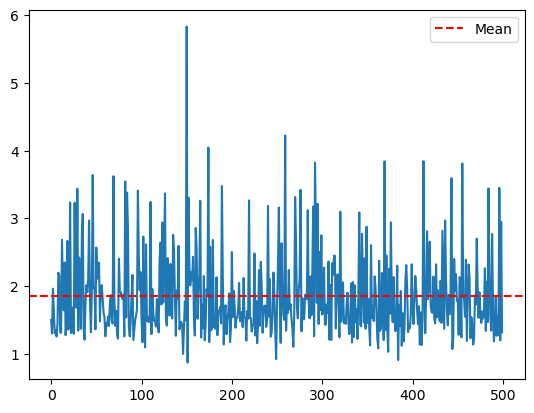

In [21]:
# Создаем логистическую регрессию
A = np.random.uniform(0, 1000, (50, 50))
b = np.random.uniform(0, 1000, 50)
regcoef = np.random.uniform(0, 100, 1)
oracle = oracles.create_log_reg_oracle(A, b, regcoef)
# 500 раз генерируем новые x и v, сохраняем среднее значение разницы
diffs = []
for _ in range(500):
    a, b = np.random.uniform(0, 100, 50), np.random.uniform(0, 100, 50)
    hess_vec_my = oracles.hess_vec_finite_diff(oracle.func, a, b)
    hess_vec_oracle = oracle.hess_vec(a, b)
    diffs.append(np.mean(np.abs(hess_vec_my - hess_vec_oracle)))

plt.plot(diffs)
plt.axhline(np.mean(diffs), color='red', linestyle='--', label='Mean')
plt.legend()

# Эксперимент 1

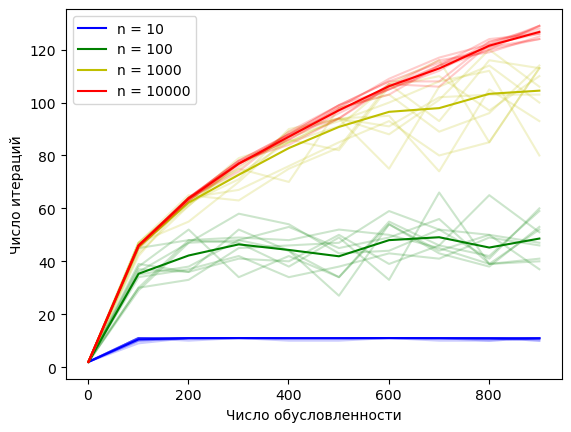

In [44]:
# словарь: размерность - цвет на графике
n_param = {10:'b', 100:'g', 1000:'y', 10000:'r'}

# число обусловленности
k_param = list(range(1, 1000, 100))

# random_seeds для повторения эксперимента
random_seeds = np.arange(1, 100, 10)

plt.xlabel('Число обусловленности')
plt.ylabel('Число итераций')

for n in n_param.keys():
    T_mean = np.zeros(len(k_param))
    for i in range(len(random_seeds)):
        T = []
        for k in k_param:
            np.random.seed(random_seeds[i] + k)
            elements = np.random.uniform(1, k, n)
            elements[0], elements[1] = 1, k
            A = scipy.sparse.diags(elements)
            b = np.random.rand(n)
            matvec = lambda x: A @ x
            x_star, msg, history = optimization.conjugate_gradients(matvec, b, np.zeros(n),
                                                                     trace=True)
            T.append(len(history['residual_norm']))
            
        T_mean += np.array(T)
        plt.plot(k_param, T, n_param[n], alpha=0.2)
        
    T_mean = T_mean / len(random_seeds)
    plt.plot(k_param, T_mean, n_param[n], label='n = '+str(n))
plt.legend()
plt.savefig('experiment1.png', dpi=150)

# Эксперимент 2

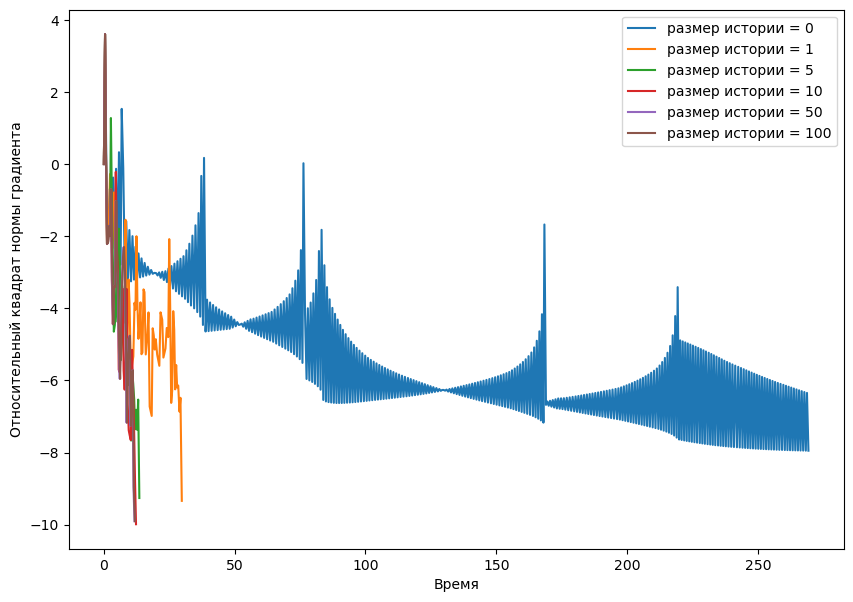

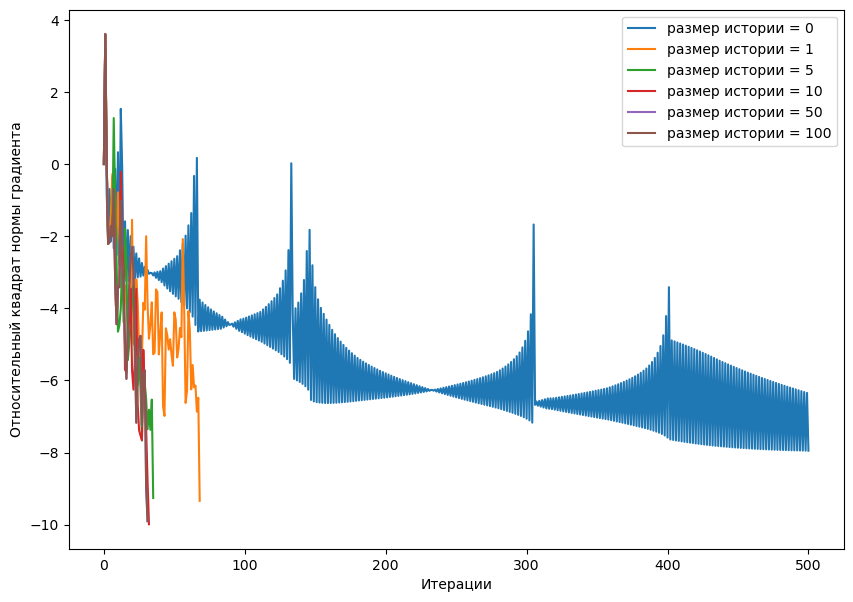

In [26]:
# варианты выбора размера истории
memory_sizes = [0, 1, 5, 10, 50, 100]
# читаем файл
A, b = load_svmlight_file('gisette_scale')
# создаем логистическую регрессию
oracle = oracles.create_log_reg_oracle(A, b, 1 / A.shape[0])
# начальная точка
x_0 = np.zeros(A.shape[1])
res = []
for l in memory_sizes:
    x_k, message, history = optimization.lbfgs(oracle, x_0, memory_size=l, trace=True)
    relative_grad = np.log([(np.linalg.norm(history['grad_norm'][i])**2) / (np.linalg.norm(history['grad_norm'][0])**2) for i in range(len(history['grad_norm']))])
    res.append((l, relative_grad, history['time']))

plt.figure(figsize=(10, 7))
plt.xlabel('Время')
plt.ylabel('Относительный квадрат нормы градиента')
for l, relative_grad, t in res:
    plt.plot(t, relative_grad, label='размер истории = {}'.format(l))
plt.legend()
plt.savefig('exp2_graph1')

plt.figure(figsize=(10, 7))
plt.xlabel('Итерации')
plt.ylabel('Относительный квадрат нормы градиента')
for l, relative_grad, t in res:
    plt.plot(list(range(len(relative_grad))), relative_grad, label='размер истории = {}'.format(l))
plt.legend()
plt.savefig('exp2_graph2')

# Эксперимент 3

в процессе: w8a
<function hessian_free_newton at 0x0000019FA2DA4A60> вычисляется
<function lbfgs at 0x0000019FA2DA49D0> вычисляется
<function gradient_descent at 0x0000019FA2DA4AF0> вычисляется
в процессе: gisette_scale
<function hessian_free_newton at 0x0000019FA2DA4A60> вычисляется
<function lbfgs at 0x0000019FA2DA49D0> вычисляется
<function gradient_descent at 0x0000019FA2DA4AF0> вычисляется
в процессе: real-sim
<function hessian_free_newton at 0x0000019FA2DA4A60> вычисляется
<function lbfgs at 0x0000019FA2DA49D0> вычисляется
<function gradient_descent at 0x0000019FA2DA4AF0> вычисляется


C:\Users\PC\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


в процессе: news20.binary
<function hessian_free_newton at 0x0000019FA2DA4A60> вычисляется
<function lbfgs at 0x0000019FA2DA49D0> вычисляется
<function gradient_descent at 0x0000019FA2DA4AF0> вычисляется
в процессе: rcv1_train.binary
<function hessian_free_newton at 0x0000019FA2DA4A60> вычисляется
<function lbfgs at 0x0000019FA2DA49D0> вычисляется
<function gradient_descent at 0x0000019FA2DA4AF0> вычисляется


<Figure size 640x480 with 0 Axes>

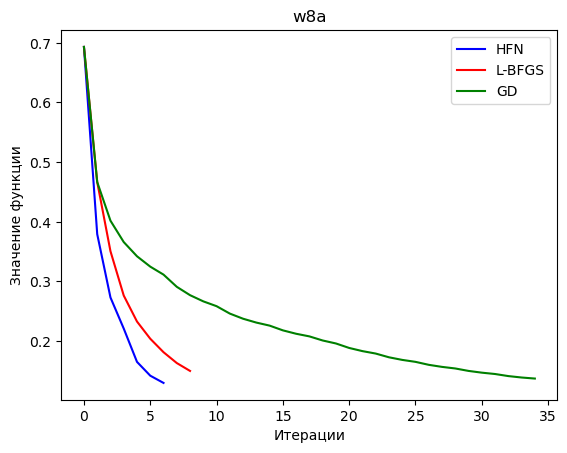

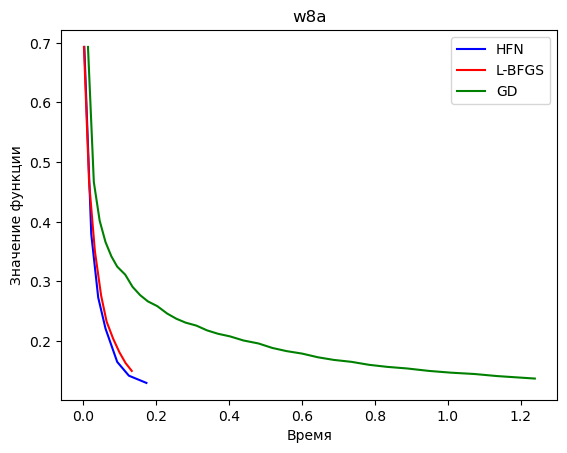

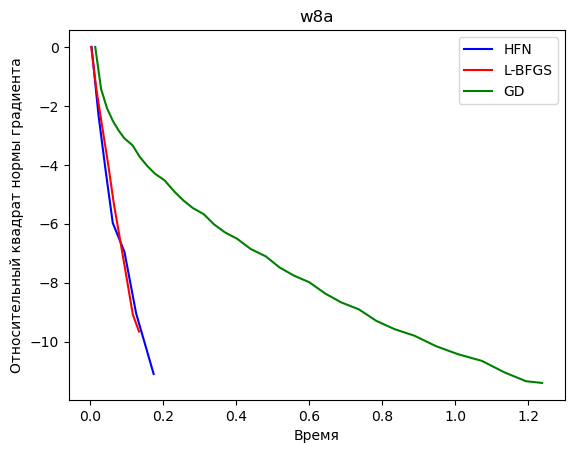

<Figure size 640x480 with 0 Axes>

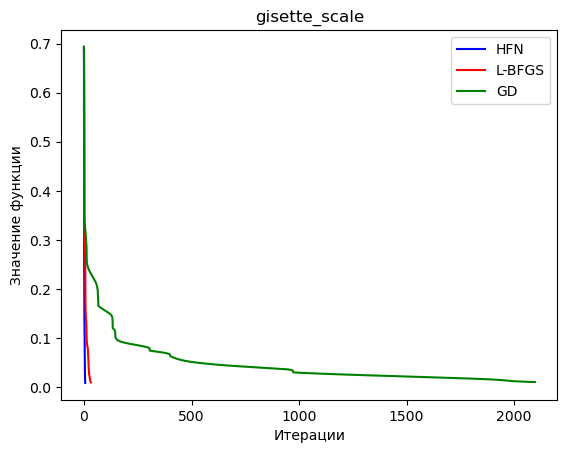

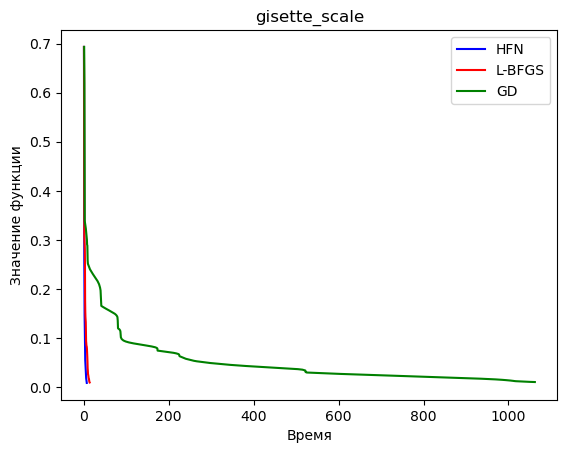

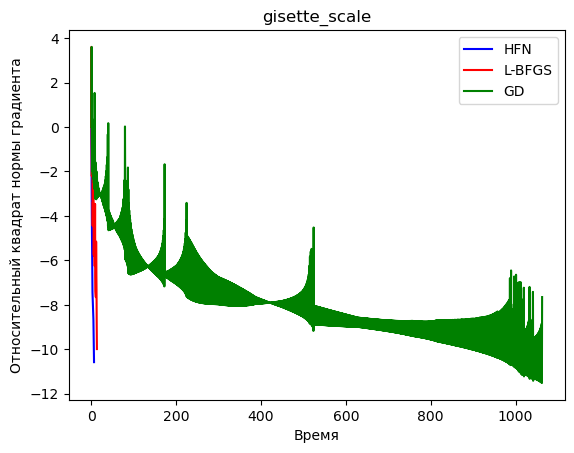

<Figure size 640x480 with 0 Axes>

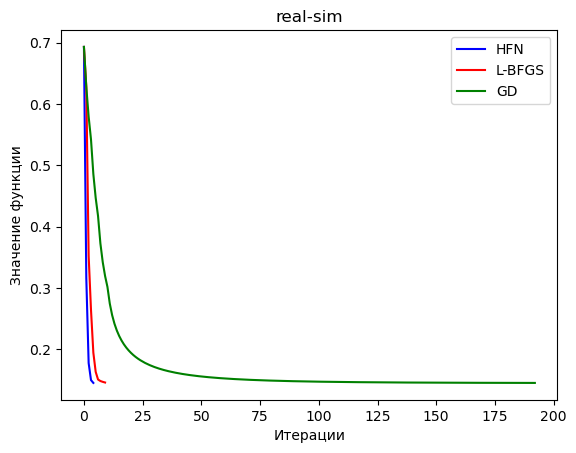

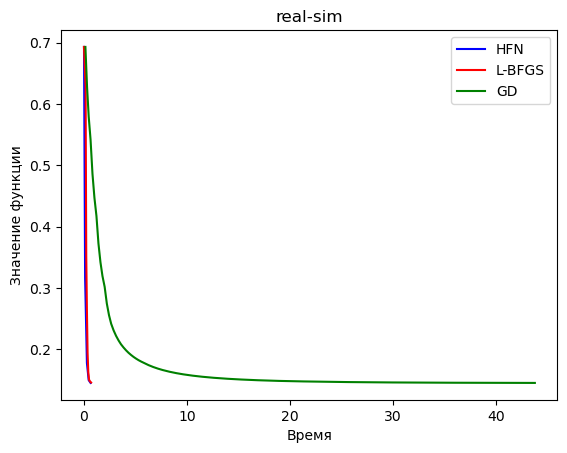

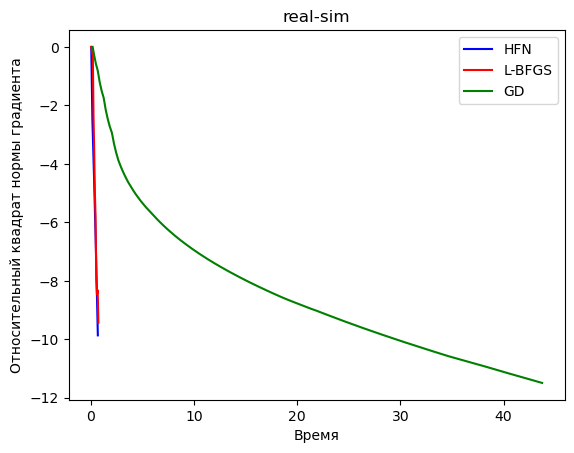

<Figure size 640x480 with 0 Axes>

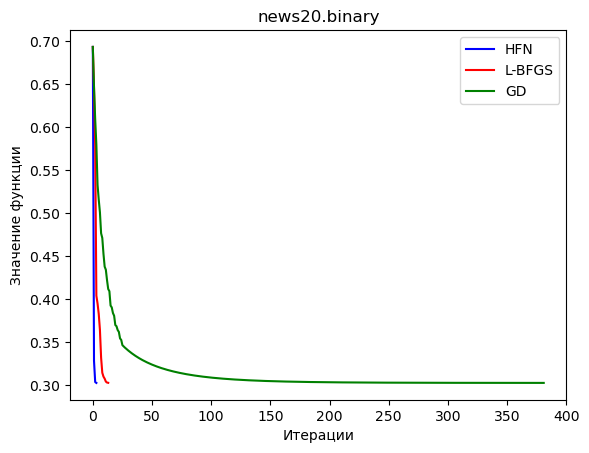

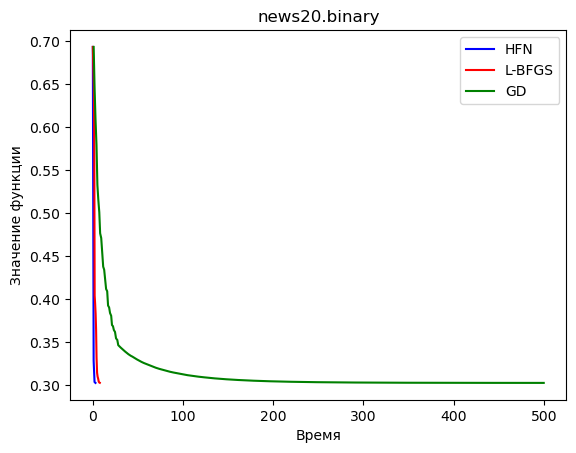

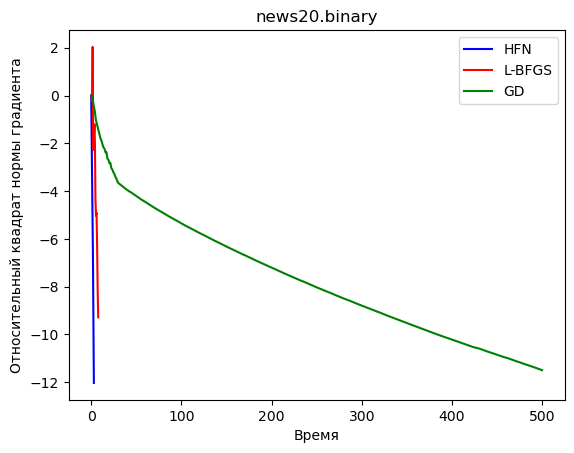

<Figure size 640x480 with 0 Axes>

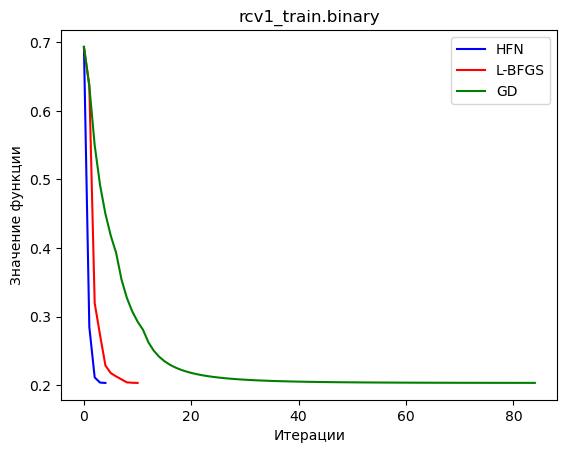

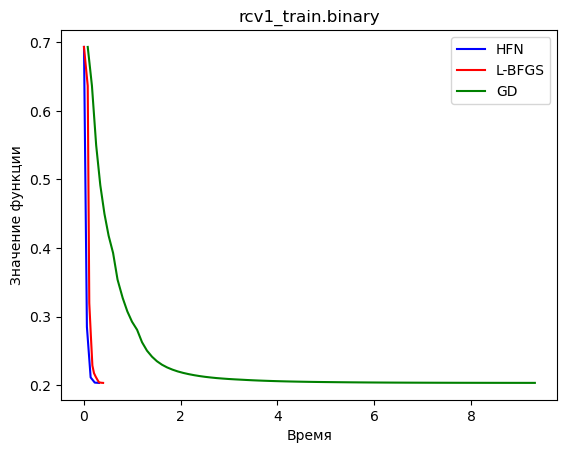

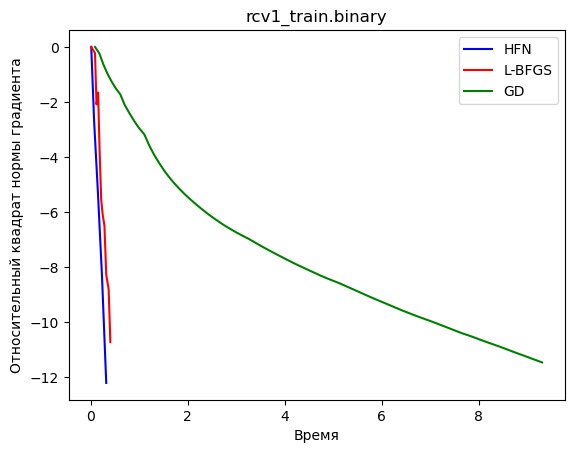

In [2]:
# Функция для графика зависимости значения функции от итерации
def graph_iter_func(result, dataset):
    plt.figure()
    for i, algo in enumerate([optimization.hessian_free_newton, optimization.lbfgs, optimization.gradient_descent]): 
        plt.plot(list(range(len(result[i]['time']))), result[i]['func'], label=titles[i], color=colors[i])
    plt.title(dataset)
    plt.xlabel('Итерации')
    plt.ylabel('Значение функции')
    plt.legend()
    plt.savefig('{}_IterFunc.png'.format(dataset))

# Функция для графика зависимости значения функции от времени
def graph_time_func(result, dataset):
    plt.figure()
    for i, algo in enumerate([optimization.hessian_free_newton, optimization.lbfgs, optimization.gradient_descent]): 
        plt.plot(result[i]['time'], result[i]['func'], label=titles[i], color=colors[i])
    plt.title(dataset)
    plt.xlabel('Время')
    plt.ylabel('Значение функции')
    plt.legend()
    plt.savefig('{}_TimeFunc.png'.format(dataset))
    
# Функция для графика зависимости относительного квадрата нормы градиента от времени    
def graph_time_relative_grad(result, dataset):
    plt.figure()
    for i, algo in enumerate([optimization.hessian_free_newton, optimization.lbfgs, optimization.gradient_descent]): 
        relative_grad = np.log([(np.linalg.norm(result[i]['grad_norm'][j])**2) / (np.linalg.norm(result[i]['grad_norm'][0])**2) for j in range(len(result[i]['grad_norm']))])
        plt.plot(result[i]['time'], relative_grad, label=titles[i], color=colors[i])
    plt.title(dataset)
    plt.xlabel('Время')
    plt.ylabel('Относительный квадрат нормы градиента')
    plt.legend()
    plt.savefig('{}_TimeRelatGrad.png'.format(dataset))

colors = ['b', 'r', 'g']
titles = ['HFN', 'L-BFGS', 'GD']
for data in ['w8a', 'gisette_scale', 'real-sim', 'news20.binary','rcv1_train.binary']:
    print('в процессе:', data)
    A, b = load_svmlight_file(data)
    oracle = oracles.create_log_reg_oracle(A, b, 1 / A.shape[0])
    x_0 = np.zeros(A.shape[1])
    results = []
    plt.figure()
    for algo in [optimization.hessian_free_newton, optimization.lbfgs, optimization.gradient_descent]:
        print('{} вычисляется'.format(str(algo)))
        x_k, message, history = algo(oracle, x_0, trace=True)
        results.append(history)
    graph_iter_func(results, data)
    graph_time_func(results, data)
    graph_time_relative_grad(results, data)       